<a href="https://colab.research.google.com/github/yagiyuki/axross/blob/main/Permutation_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Permutation Importanceを活用した特徴量の重要度評価のレシピ

## レシピの概要

このレシピでは、機械学習における特徴量の重要度評価手法として、Permutation Importanceを紹介します。

機械学習の特徴量の重要度評価は、Feature Importanceによるものが有名である。

GoogleTrendで調べても、Feature Importanceのほうが検索実績が多いことがわかる。

このレシピでは、Feature Importanceとの比較をしつつ、  Permutation Importanceによる特徴量の重要度評価を学んでいきます。

## 前提知識
* python (基本構文であるif, for などが理解できる。)
* sklearn, pandasなどのライブラリを扱える(写経できる)
* 機械学習の教師あり学習の概念がわかる

## 達成できること

* "Feature Importance"と"Permutation Importance"による特徴量の重要度評価・可視化の方法を学べる
* "Permutation Importance"を活用した精度改善の方法を学べる

## 材料・道具

### 実行環境
Google Colaboratory

### 道具
* python
* pandas
* matplotlib
* seaborn
* numpy
* scipy
* sklearn

## 材料
学習・評価データとして、タイタニック号のデータを使います。  
https://github.com/mwaskom/seaborn-data/blob/master/titanic.csv

## 必要なモジュールのImport

## データの取得・前処理


In [3]:
# 必要モジュールのImport
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
# タイタニックのデータ号のデータ取得
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


In [5]:
# 文字列形式のデータを数値に置き換え
encode_cols = ['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']

for f in encode_cols:
    lbl = LabelEncoder()
    df[f] = lbl.fit_transform(list(df[f].values))

In [6]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,2,2,1,1,7,2,0,0
1,1,1,0,38.0,1,0,71.2833,0,0,2,0,2,0,1,0
2,1,3,0,26.0,0,0,7.9250,2,2,2,0,7,2,1,1
3,1,1,0,35.0,1,0,53.1000,2,0,2,0,2,2,1,0
4,0,3,1,35.0,0,0,8.0500,2,2,1,1,7,2,0,1


In [7]:
# 数値系データの欠損値を平均値で補完
encode_cols = ['age', 'fare']

for f in encode_cols:
    df[f].fillna(df[f].mean(), inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    int64  
 3   age          891 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     891 non-null    int64  
 8   class        891 non-null    int64  
 9   who          891 non-null    int64  
 10  adult_male   891 non-null    int64  
 11  deck         891 non-null    int64  
 12  embark_town  891 non-null    int64  
 13  alive        891 non-null    int64  
 14  alone        891 non-null    int64  
dtypes: float64(2), int64(13)
memory usage: 104.5 KB


In [9]:
# 生存を予測するモデルを作るので、特徴量は['survived', 'alive']を外したものとする
X = df.drop(['survived', 'alive'], axis=1)
# 目的変数はsurvivedとする。
y = df['survived'].values

In [61]:
# 学習データ: テストデータ=8:2で分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## ランダムフォレストで学習

In [62]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

In [63]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred[:5])
print(accuracy_score(y_test, y_pred))

[0 0 0 0 1]
0.8156424581005587


## Feature Importanceによる評価

各特徴量の分類寄与率を評価する指標です。  
より詳細には、「ある特徴量で分割することでどれくらいジニ不純度を下げられるのか」ということになります。  





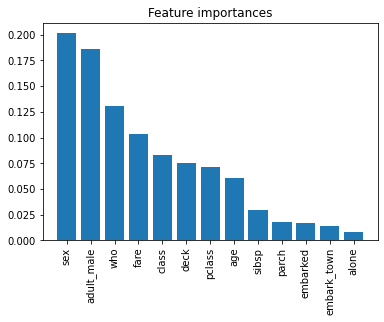

In [67]:
# Feature Importanceによる重要度の可視化
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

## Permutation Importanceによる評価

In [65]:
permutation_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0)

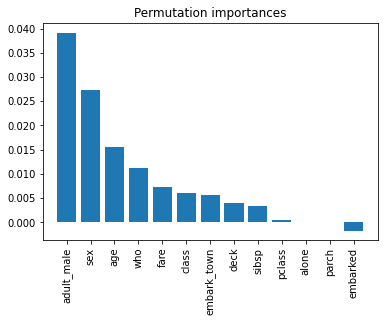

In [66]:
importances = permutation_result.importances_mean # ここをかえる。
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Permutation importances")
plt.bar(range(X_test.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
X_train = X_train.drop(["parch"], axis=1)
X_test = X_test.drop(["parch"], axis=1)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred[:5])

[0 0 0 0 1]


In [ ]:
accuracy_score(y_test, y_pred)

0.8044692737430168

In [ ]:
permutation_result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=0)

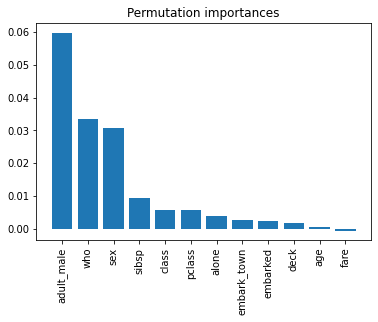

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

importances = permutation_result.importances_mean # ここをかえるだけ
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Permutation importances")
plt.bar(range(X_test.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
plt.show()

In [ ]:
# 学習データ: テストデータ=8:2で分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=2.0, max_iter=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8379888268156425

In [ ]:
permutation_result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=0)

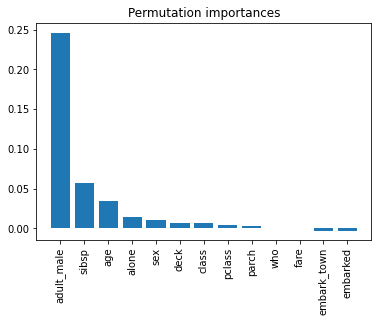

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

importances = permutation_result.importances_mean # ここをかえるだけ
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Permutation importances")
plt.bar(range(X_test.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
plt.show()

In [ ]:
X_train = X_train.drop(["embark_town", "embarked"], axis=1)
X_test = X_test.drop(["embark_town", "embarked"], axis=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=2.0, max_iter=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8435754189944135

In [ ]:
permutation_result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=0)

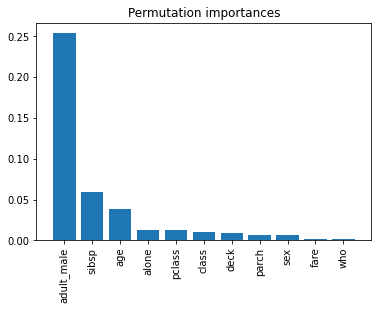

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

importances = permutation_result.importances_mean # ここをかえるだけ
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Permutation importances")
plt.bar(range(X_test.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
plt.show()